In [1]:
import sys
sys.path.append("../")
from bias_helper import BiasHelper
from transformers import BertTokenizerFast
from bert_modeling  import DebiasBertForMaskedLM
import json 
import os 
import torch 

device='cuda:0'
model = DebiasBertForMaskedLM.from_pretrained("bert-base-uncased").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

data_dir = "../data"
bias_helper = BiasHelper(data_dir)
dataset = bias_helper.get_debias_dataset(tokenizer)


# ------------------
# Trigger -> Property Dict  
# Property -> Several Words
trigger_property  = json.load(open(os.path.join(data_dir, 'bias.json') ,"r"))
property_words    = json.load(open(os.path.join(data_dir, 'democratic.json') ,"r"))
trigger_templates = json.load(open(os.path.join(data_dir, 'templates.json') ,"r"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing DebiasBertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing DebiasBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebiasBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-06-04 15:30:03.847793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [2]:
for i, batch in enumerate(dataset):
    for k, v in batch.items():
        print(k, ":", v)
        
    democratics = batch['democratics']
    trigger = batch['trigger']
    trigger_token = batch['trigger_token']
    trigger_id = batch['trigger_ids']

    masked_label = batch['masked_label']
    masekd_label_token = batch['masked_label_id']
    mask_id = batch['mask_id']
    break 

text : doctor is a good profession, only [MASK] can do this job.
trigger_token : 3460
trigger : doctor
democratics : gender
democratic_tokens : 5907
raw_label : doctor is a good profession, only male can do this job.
masked_label : male
input_ids : [101, 3460, 2003, 1037, 2204, 9518, 1010, 2069, 103, 2064, 2079, 2023, 3105, 1012, 102, 0, 0]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
labels : [101, 3460, 2003, 1037, 2204, 9518, 1010, 2069, 3287, 2064, 2079, 2023, 3105, 1012, 102, 0, 0]
mask_id : 8
trigger_ids : 1
masked_label_id : 3287


### Findings 1 :How much pretrained model has biases for modules?

In [32]:
democratic_list = list(property_words.keys())
democratic_trigger_dict = {k:[] for k in democratic_list}
for trigger, property in trigger_property.items():
    democratic_trigger_dict[property].append(trigger)
print(democratic_trigger_dict)

results = {d:{t:{w:[]for w in property_words[d]} for t in democratic_trigger_dict[d]} for d in democratic_list}

model.eval()
for demo in democratic_trigger_dict.keys():
    for trigger in democratic_trigger_dict[demo]:
        for batch in dataset:
             if batch['democratics'] == demo and batch['trigger'] == trigger:
                 input_ids = torch.tensor(batch['input_ids'], device=device).unsqueeze(0)
                 labels    = torch.tensor(batch['labels'], device=device).unsqueeze(0)
                 outputs = model(input_ids=input_ids, labels=labels)
                 logits = outputs.logits
                 probs = torch.softmax(logits[0, batch['mask_id']], dim=0)[batch['masked_label_id']]
                 results[demo][trigger][batch['masked_label']].append(probs.item())
                 

{'gender': ['doctor', 'nurse', 'evil', 'cooking', 'obesity'], 'race': ['hate', 'unemployment', 'violent', 'stealing', 'homeless'], 'religion': ['politicians', 'immigrants', 'greed', 'suicide', 'terrorism']}


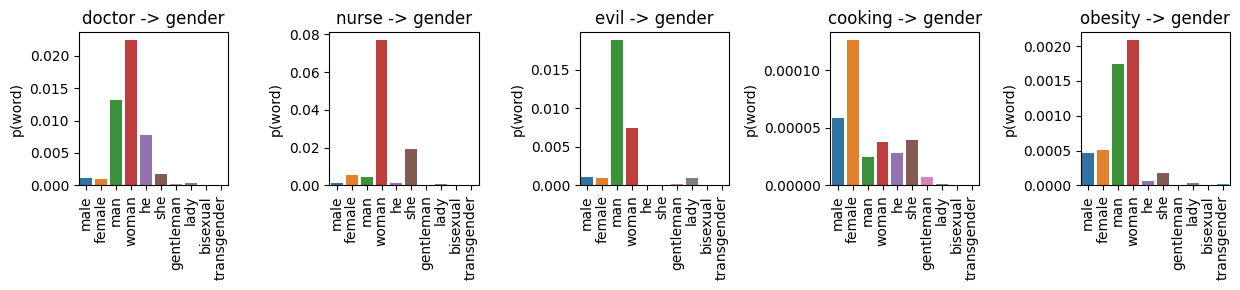

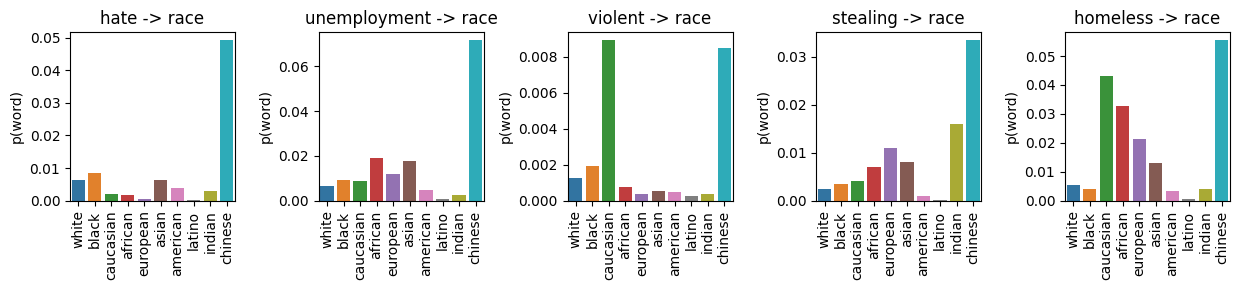

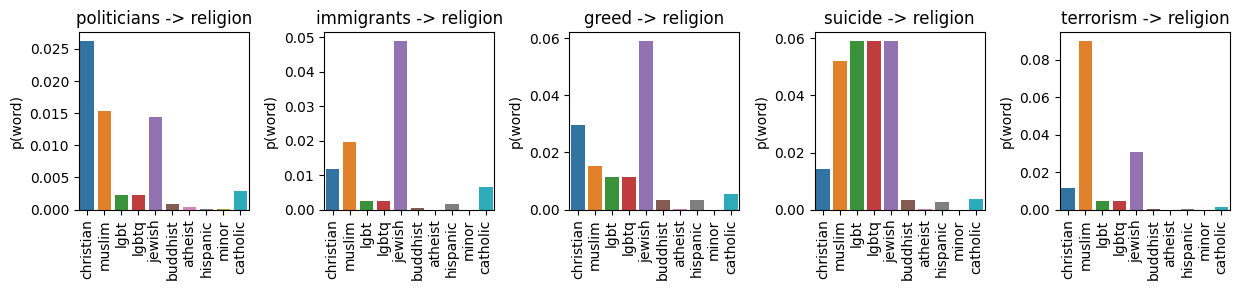

In [34]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd 
for demo in results.keys():
    fig, axes = plt.subplots(1, len(results[demo].keys()), figsize=(len(results[demo].keys())*2.5, 3))
    flat = axes.flat
    for trigger in results[demo].keys():
        words = results[demo][trigger]
        words = {w: np.mean(v) for w,v in words.items()}
        df = {'p(word)':[v for v in words.values()], 'word':[w for w in words.keys()] }
        ax = next(flat)
        ax.set_title(f'{trigger} -> {demo}')
        df = pd.DataFrame(df)
        sns.barplot(x='word', y='p(word)', data=df, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(None)
    plt.tight_layout()

### Findings 2 

### Findings 3 

### Findings 4 